#*Connecting with Google Drive*

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Transfer Learning MNIST

* Train a simple convnet on the MNIST dataset the first 5 digits [0..4].
* Freeze convolutional layers and fine-tune dense layers for the classification of digits [5..9].

## 1. Import necessary libraries for the model

In [2]:
# Import Basic Libraries
import numpy as np
import pandas as pd
import os

# To read Zip File
from zipfile import ZipFile

# Import Datavisualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import toimage

# Set Theme for Data Visualization
%matplotlib inline
sns.set_style('whitegrid')

# Mitigating Warnings
import warnings
warnings.filterwarnings('ignore')

# For time based calculations
import time

# Import TensorFlow and Keras
import tensorflow as tf
import keras

# Import Open CV - For Image Processing
import cv2

# Import Modules from Keras for CNN Modeling
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, Activation, Flatten, Reshape
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.optimizers import adam

# Import Libraries for Train-Test split, Scaling and Metric calculation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
#Reset Default graph - Needed only for Jupyter notebook
tf.reset_default_graph()
tf.set_random_seed(10)

## 2. Import MNIST data and create 2 datasets with one dataset having digits from 0 to 4 and other from 5 to 9 

In [0]:
(trainX, trainY), (testX, testY) = keras.datasets.mnist.load_data()

In [5]:
# Shape of Train and Test Data

print("Train X:",trainX.shape)

print("Train Y:",trainY.shape)

print("Test X:",testX.shape)

print("Test Y:",testY.shape)

Train X: (60000, 28, 28)
Train Y: (60000,)
Test X: (10000, 28, 28)
Test Y: (10000,)


In [0]:
# Mask 1 for digits between 0 - 4
train_mask_1 = np.isin(trainY, [0,1,2,3,4])
test_mask_1 = np.isin(testY, [0,1,2,3,4])

# Mask 2 for digits between 5 - 9
train_mask_2 = np.isin(trainY, [5,6,7,8,9])
test_mask_2 = np.isin(testY, [5,6,7,8,9])

In [7]:
print("train_mask_1:",train_mask_1)
print("test_mask_1:",test_mask_1)
print("train_mask_2:",train_mask_2)
print("test_mask_2:",test_mask_2)

train_mask_1: [False  True  True ... False False False]
test_mask_1: [False  True  True ...  True False False]
train_mask_2: [ True False False ...  True  True  True]
test_mask_2: [ True False False ... False  True  True]


In [0]:
# Use of mask to divide the dataset 0 - 4

X_train1, Y_train1 = trainX[train_mask_1], trainY[train_mask_1]
X_test1, Y_test1 = testX[test_mask_1], testY[test_mask_1]

In [9]:
# Shape of Train and Test Data (0 - 4)

print("Train X (0-4):",X_train1.shape)

print("Train Y (0-4):",Y_train1.shape)

print("Test X (0-4):",X_test1.shape)

print("Test Y (0-4):",Y_test1.shape)

Train X (0-4): (30596, 28, 28)
Train Y (0-4): (30596,)
Test X (0-4): (5139, 28, 28)
Test Y (0-4): (5139,)


In [10]:
print(Y_train1)

[0 4 1 ... 2 1 3]


In [0]:
# Use of mask to divide the dataset 5 - 9

X_train2, Y_train2 = trainX[train_mask_2], trainY[train_mask_2]
X_test2, Y_test2 = testX[test_mask_2], testY[test_mask_2]

In [12]:
# Shape of Train and Test Data (5 - 9)

print("Train X (5-9):",X_train2.shape)

print("Train Y (5-9):",Y_train2.shape)

print("Test X (5-9):",X_test2.shape)

print("Test Y (5-9):",Y_test2.shape)

Train X (5-9): (29404, 28, 28)
Train Y (5-9): (29404,)
Test X (5-9): (4861, 28, 28)
Test Y (5-9): (4861,)


In [13]:
print(Y_train2)

[5 9 5 ... 5 6 8]


## 3. Print x_train, y_train, x_test and y_test for both the datasets

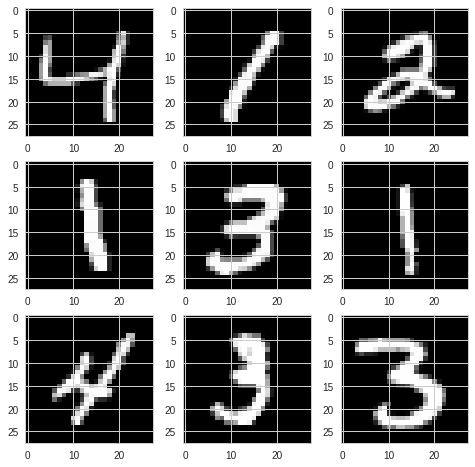

In [14]:
# X_train1 Images (0 - 4)
w=8
h=8
fig=plt.figure(figsize=(w, h))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = X_train1[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()



## ** 4. Let us take only the dataset (x_train, y_train, x_test, y_test) for Integers 0 to 4 in MNIST **
## Reshape x_train and x_test to a 4 Dimensional array (channel = 1) to pass it into a Conv2D layer

In [0]:
X_train1 = X_train1.astype('float32')
X_test1 = X_test1.astype('float32')

In [17]:
X_train1 = X_train1.reshape(X_train1.shape[0],28,28,1)
X_test1 = X_test1.reshape(X_test1.shape[0],28,28,1)

print("Shape of Training Set (0-4):",X_train1.shape)
print("Shape of Test Set (0-4):",X_test1.shape)

Shape of Training Set (0-4): (30596, 28, 28, 1)
Shape of Test Set (0-4): (5139, 28, 28, 1)


## 5. Normalize x_train and x_test by dividing it by 255

In [0]:
#Normalizing the input
X_train1 /= 255
X_test1 /= 255

## 6. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [0]:
# convert class vectors to binary class matrices
Y_train1 = keras.utils.to_categorical(Y_train1, 5)
Y_test1 = keras.utils.to_categorical(Y_test1, 5)

In [20]:
print("Shape of Training Labels (0-4):",Y_train1.shape)
print("Shape of Test Labels (0-4):",Y_test1.shape)

Shape of Training Labels (0-4): (30596, 5)
Shape of Test Labels (0-4): (5139, 5)


## 7. Build a sequential model with 2 Convolutional layers with 32 kernels of size (3,3) followed by a Max pooling layer of size (2,2) followed by a drop out layer to be trained for classification of digits 0-4  

In [21]:
# Define Model
    model = Sequential()

    # 1st Conv Layer
    model.add(Convolution2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1),name='conv_1'))


    # 2nd Conv Layer
    model.add(Convolution2D(32, (3, 3), activation='relu',name='conv_2'))

    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
    
    # Dropout
    model.add(Dropout(0.25,name='drop_1'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 8. Post that flatten the data and add 2 Dense layers with 128 neurons and neurons = output classes with activation = 'relu' and 'softmax' respectively. Add dropout layer inbetween if necessary  

In [0]:
# Fully Connected Layer - Dense Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu',name='dense_1'))
    
# Prediction Layer
    model.add(Dense(5, activation='softmax',name='dense_2'))

In [0]:
TRAIN = False
BATCH_SIZE = 64
EPOCHS = 10

In [0]:
# Loss and Optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Store Training Results
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, verbose=1, mode='auto')
    callback_list = [early_stopping]

In [25]:
# Train the model1
    model.fit(X_train1, Y_train1, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, 
              validation_data=(X_test1, Y_test1), callbacks=callback_list)

Instructions for updating:
Use tf.cast instead.
Train on 30596 samples, validate on 5139 samples
Epoch 1/10
30596/30596 [==============================] - 9s 306us/step - loss: 0.0816 - acc: 0.9745 - val_loss: 0.0199 - val_acc: 0.9932
Epoch 2/10
30596/30596 [==============================] - 6s 195us/step - loss: 0.0213 - acc: 0.9937 - val_loss: 0.0114 - val_acc: 0.9971
Epoch 3/10
30596/30596 [==============================] - 6s 195us/step - loss: 0.0131 - acc: 0.9955 - val_loss: 0.0079 - val_acc: 0.9969
Epoch 4/10
30596/30596 [==============================] - 6s 194us/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 5/10
30596/30596 [==============================] - 6s 193us/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0060 - val_acc: 0.9977
Epoch 6/10
30596/30596 [==============================] - 6s 192us/step - loss: 0.0039 - acc: 0.9986 - val_loss: 0.0058 - val_acc: 0.9988
Epoch 7/10
30596/30596 [==============================] - 6s 185us/step - l

## 9. Print the training and test accuracy

In [26]:
# Model Accuracy
score_train = model.evaluate(X_train1, Y_train1)
score_test = model.evaluate(X_test1, Y_test1)
print()
print('Training accuracy: ', score_train[1])
print('Test accuracy: ', score_test[1])

5139/5139 [==============================] - 1s 98us/step

Training accuracy:  0.9990848476925088
Test accuracy:  0.9974703249659467


## 10. Make only the dense layers to be trainable and convolutional layers to be non-trainable

In [27]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model.layers:
  if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

conv_1
False
conv_2
False
max_1
False
drop_1
False
flatten_1
False
dense_1
True
dense_2
True


## 11. Use the model trained on 0 to 4 digit classification and train it on the dataset which has digits 5 to 9  (Using Transfer learning keeping only the dense layers to be trainable)

In [0]:
# Convert to Float
X_train2 = X_train2.astype('float32')
X_test2 = X_test2.astype('float32')

# Reshape training and testing
X_train2 = X_train2.reshape(X_train2.shape[0],28,28,1)
X_test2 = X_test2.reshape(X_test2.shape[0],28,28,1)

#Normalizing the input
X_train2 /= 255
X_test2 /= 255

In [0]:
# Convert class vectors to binary class matrices
Y_train2 = keras.utils.to_categorical(Y_train2-5)
Y_test2 = keras.utils.to_categorical(Y_test2-5)

In [30]:
# Train the model
    model.fit(X_train2, Y_train2, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, 
              validation_data=(X_test2, Y_test2), callbacks=callback_list)

Train on 29404 samples, validate on 4861 samples
Epoch 1/10
29404/29404 [==============================] - 5s 181us/step - loss: 0.1154 - acc: 0.9705 - val_loss: 0.0290 - val_acc: 0.9895
Epoch 2/10
29404/29404 [==============================] - 5s 175us/step - loss: 0.0253 - acc: 0.9920 - val_loss: 0.0211 - val_acc: 0.9928
Epoch 3/10
29404/29404 [==============================] - 5s 170us/step - loss: 0.0153 - acc: 0.9948 - val_loss: 0.0196 - val_acc: 0.9934
Epoch 4/10
29404/29404 [==============================] - 5s 171us/step - loss: 0.0093 - acc: 0.9972 - val_loss: 0.0190 - val_acc: 0.9940
Epoch 5/10
29404/29404 [==============================] - 5s 169us/step - loss: 0.0072 - acc: 0.9974 - val_loss: 0.0191 - val_acc: 0.9942
Epoch 6/10
29404/29404 [==============================] - 5s 166us/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.0230 - val_acc: 0.9944
Epoch 7/10
29404/29404 [==============================] - 5s 164us/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.0330 - v

## 12. Print the accuracy for classification of digits 5 to 9

In [31]:
# Model Accuracy
score_train = model.evaluate(X_train2, Y_train2)
score_test = model.evaluate(X_test2, Y_test2)
print()
print('Training accuracy: ', score_train[1])
print('Test accuracy: ', score_test[1])

4861/4861 [==============================] - 0s 103us/step

Training accuracy:  0.9998299551081485
Test accuracy:  0.9954741822670232


## Sentiment analysis <br> 

The objective of the second problem is to perform Sentiment analysis from the tweets data collected from the users targeted at various mobile devices.
Based on the tweet posted by a user (text), we will classify if the sentiment of the user targeted at a particular mobile device is positive or not.

### 13. Read the dataset (tweets.csv) and drop the NA's while reading the dataset

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/AIML/Residency 8/R8_Internal Lab/R8_Internal Lab/tweets.csv", na_filter=True, encoding='ISO-8859-1')

In [33]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [34]:
data.shape

(9093, 3)

In [0]:
data = data.dropna()

In [36]:
data.shape

(3291, 3)

### 14. Preprocess the text and add the preprocessed text in a column with name `text` in the dataframe.

In [0]:
def preprocess(text):
    try:
        return text.decode('ascii')
    except Exception as e:
        return ""

In [0]:
data['text'] = [preprocess(text) for text in data.tweet_text]

### 15. Consider only rows having Positive emotion and Negative emotion and remove other rows from the dataframe.

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9088
Data columns (total 4 columns):
tweet_text                                            3291 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    3291 non-null object
text                                                  3291 non-null object
dtypes: object(4)
memory usage: 128.6+ KB


In [0]:
tweet_df = data[((data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion'))]

In [41]:
tweet_df.shape

(3191, 4)

In [42]:
tweet_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Positive emotion    2672
Negative emotion     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### 16. Represent text as numerical data using `CountVectorizer` and get the document term frequency matrix

#### Use `vect` as the variable name for initialising CountVectorizer.

In [0]:
X = tweet_df['tweet_text']
le1 = preprocessing.LabelEncoder()
tweet_df['Label'] = le1.fit_transform(tweet_df['is_there_an_emotion_directed_at_a_brand_or_product'])
y = tweet_df['Label']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
vect = CountVectorizer()
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

### 17. Find number of different words in vocabulary

In [47]:
tokens = vect.get_feature_names()
len(tokens)

4919

#### Tip: To see all available functions for an Object use dir

### 18. Find out how many Positive and Negative emotions are there.

Hint: Use value_counts on that column

In [48]:
tweet_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Positive emotion    2672
Negative emotion     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### 19. Change the labels for Positive and Negative emotions as 1 and 0 respectively and store in a different column in the same dataframe named 'Label'

Hint: use map on that column and give labels

In [0]:
tweet_df['Label'] = le1.fit_transform(tweet_df['is_there_an_emotion_directed_at_a_brand_or_product'])
y = tweet_df['Label']

### 20. Define the feature set (independent variable or X) to be `text` column and `labels` as target (or dependent variable)  and divide into train and test datasets

In [0]:
# Done Above

## 21. **Predicting the sentiment:**


### Use Naive Bayes and Logistic Regression and their accuracy scores for predicting the sentiment of the given text

In [0]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [52]:
nb.fit(train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred_class = nb.predict(test_dtm)

In [54]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8471177944862155

In [0]:
from sklearn.linear_model import LogisticRegression

In [56]:
logreg = LogisticRegression(C=1e6)
logreg.fit(train_dtm, y_train)
y_pred_class = logreg.predict(test_dtm)
print (metrics.accuracy_score(y_test, y_pred_class))

0.8546365914786967


## 22. Create a function called `tokenize_predict` which can take count vectorizer object as input and prints the accuracy for x (text) and y (labels)

In [0]:
def tokenize_test(vect):
    x_train_dtm = vect.fit_transform(X_train)
    print('Features: ', x_train_dtm.shape[1])
    x_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(x_train_dtm, y_train)
    y_pred_class = nb.predict(x_test_dtm)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

### Create a count vectorizer function which includes n_grams = 1,2  and pass it to tokenize_predict function to print the accuracy score

In [58]:
vect1 = CountVectorizer(ngram_range=(1,2))
tokenize_test(vect1)

Features:  24855
Accuracy:  0.8558897243107769


### Create a count vectorizer function with stopwords = 'english'  and pass it to tokenize_predict function to print the accuracy score

In [59]:
vect2 = CountVectorizer(stop_words = 'english')
tokenize_test(vect2)

Features:  4681
Accuracy:  0.8533834586466166


### Create a count vectorizer function with stopwords = 'english' and max_features =300  and pass it to tokenize_predict function to print the accuracy score

In [60]:
vect3 = CountVectorizer(stop_words = 'english', max_features = 300)
tokenize_test(vect3)

Features:  300
Accuracy:  0.8107769423558897


### Create a count vectorizer function with n_grams = 1,2  and max_features = 15000  and pass it to tokenize_predict function to print the accuracy score

In [61]:
vect4 = CountVectorizer(ngram_range=(1,2), max_features = 15000)
tokenize_test(vect4)

Features:  15000
Accuracy:  0.8533834586466166


### Create a count vectorizer function with n_grams = 1,2  and include terms that appear at least 2 times (min_df = 2)  and pass it to tokenize_predict function to print the accuracy score

In [62]:
vect5 = CountVectorizer(ngram_range=(1,2), min_df = 2)
tokenize_test(vect5)

Features:  7764
Accuracy:  0.8583959899749374
